# Analyse Exploratoire Complète (EDA) - QuickMart

## **1. Chargement et Vérification des Données**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path  # Meilleure gestion des chemins

# Configuration initiale
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)  # Afficher toutes les colonnes

# Configuration des chemins - version robuste avec Path
BASE_DIR = Path("C:/Users/Optimiste/Videos/Freelance/quickmart_analysis")
DATA_DIR = BASE_DIR / "data"

# Vérification de l'existence du dossier data
if not DATA_DIR.exists():
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    print(f"📁 Dossier créé : {DATA_DIR}")

# Dictionnaire des fichiers
DATA_FILES = {
    "sales": "ventes.csv",
    "products": "produits.csv",  # Corrigé 'produits' (il y avait une faute de frappe)
    "inventory": "stocks.csv",
    "staff": "planning_equipes.csv",
    "weather": "meteo_locale.csv",
    "marketing": "campagnes_marketing.csv"
}

def load_data(file_key, date_cols=None):
    """Charge un fichier CSV avec gestion des dates et vérification du fichier"""
    file_path = DATA_DIR / DATA_FILES[file_key]
    
    if not file_path.exists():
        raise FileNotFoundError(f"Le fichier {file_path} n'existe pas")
    
    # Chargement avec gestion automatique des dates si spécifié
    if date_cols:
        return pd.read_csv(file_path, parse_dates=date_cols)
    return pd.read_csv(file_path)

# Chargement des données avec gestion spécifique des dates
try:
    df_sales = load_data("sales", date_cols=['Date'])
    df_products = load_data("products")
    df_inventory = load_data("inventory", date_cols=['Date'])
    df_staff = load_data("staff", date_cols=['Date'])
    df_weather = load_data("weather", date_cols=['Date'])
    df_marketing = load_data("marketing", date_cols=['Date_début', 'Date_fin'])
    
    # Vérification des données chargées
    print("✅ Données chargées avec succès")
    print(f"Ventes : {df_sales.shape[0]} lignes | Produits : {len(df_products)}")
    
    # Conversion des dates (redondant avec parse_dates mais plus sûr)
    date_columns = {
        'df_sales': 'Date',
        'df_inventory': 'Date',
        'df_staff': 'Date',
        'df_weather': 'Date'
    }
    
    for df_name, col in date_columns.items():
        df = globals()[df_name]
        df[col] = pd.to_datetime(df[col])
    
    # Calcul du CA avec vérification des colonnes nécessaires
    required_cols = ['Produit_ID', 'Prix_unitaire']
    if all(col in df_products.columns for col in required_cols):
        df_sales = pd.merge(
            df_sales, 
            df_products[required_cols], 
            on='Produit_ID', 
            how='left'  # Garde toutes les ventes même sans produit référencé
        )
        
        if 'Quantité_vendue' in df_sales.columns and 'Prix_unitaire' in df_sales.columns:
            df_sales['CA'] = df_sales['Quantité_vendue'] * df_sales['Prix_unitaire']
            print("💰 Calcul du CA effectué")
        else:
            print("⚠️ Colonnes manquantes pour calculer le CA")
    else:
        print("⚠️ Colonnes Produit_ID ou Prix_unitaire manquantes dans df_products")

except Exception as e:
    print(f"❌ Erreur lors du chargement : {str(e)}")
    # Gestion des DataFrames non chargés
    for df_name in ['df_sales', 'df_products', 'df_inventory', 'df_staff', 'df_weather', 'df_marketing']:
        globals()[df_name] = pd.DataFrame()  # Crée des DataFrames vides pour éviter les erreurs

✅ Données chargées avec succès
Ventes : 4550 lignes | Produits : 20
💰 Calcul du CA effectué


## **2. Analyse des Ventes (df_sales)**
### A. Structure des Données

In [5]:
print("📊 Dimensions:", df_sales.shape)
print("\n🔍 Aperçu:")
display(df_sales.head())

print("\n📅 Plage temporelle:")
print("Début:", df_sales['Date'].min())
print("Fin:", df_sales['Date'].max())

📊 Dimensions: (4550, 7)

🔍 Aperçu:


,Date,Magasin,Produit_ID,Quantité_vendue,Canal,Prix_unitaire,CA
0,2024-01-01,Magasin_1,Produit_8,2,Sur place,13.13,26.26
1,2024-01-01,Magasin_1,Produit_4,6,Sur place,9.38,56.28
2,2024-01-01,Magasin_1,Produit_5,7,À emporter,3.18,22.26
3,2024-01-01,Magasin_1,Produit_2,2,Sur place,14.31,28.62
4,2024-01-01,Magasin_1,Produit_19,5,À emporter,7.05,35.25



📅 Plage temporelle:
Début: 2024-01-01 00:00:00
Fin: 2024-03-31 00:00:00


**Performance Globale**

In [8]:
print(f"📅 Période analysée: {df_sales['Date'].min().date()} au {df_sales['Date'].max().date()}")
print(f"💰 CA Total: {df_sales['CA'].sum():,.0f}€")
print(f"🛒 Transactions Moyennes: {df_sales['Quantité_vendue'].mean():.1f} produits/transaction")

📅 Période analysée: 2024-01-01 au 2024-03-31
💰 CA Total: 169,984€
🛒 Transactions Moyennes: 5.0 produits/transaction


### B. Répartition par Canal

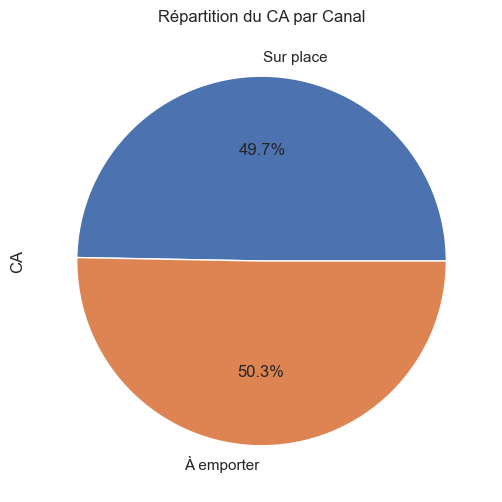

In [11]:
plt.figure(figsize=(8,6))
df_sales.groupby('Canal')['CA'].sum().plot.pie(autopct='%1.1f%%')
plt.title("Répartition du CA par Canal");

### C. Top Produits

In [14]:
top_produits = df_sales.groupby('Produit_ID').agg({
    'Quantité_vendue': 'sum',
    'CA': 'sum'
}).sort_values('CA', ascending=False).head(10)

display(top_produits.style.background_gradient(cmap='Blues'))

,Quantité_vendue,CA
Produit_ID,,
Produit_12,1148,16737.840000
Produit_8,1181,15506.530000
Produit_2,1063,15211.530000
Produit_13,1188,15028.200000
Produit_3,1150,12937.500000
Produit_4,1333,12503.540000
Produit_10,1066,11630.060000
Produit_9,1137,10710.540000
Produit_18,1167,9744.450000


## **3. Analyse des Stocks**
### A. Niveau de Stock vs Ventes

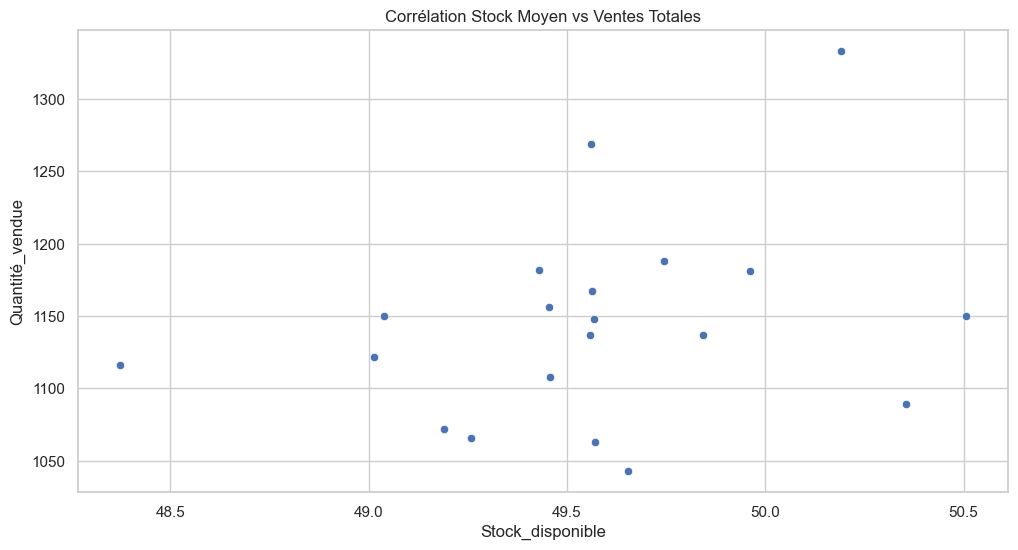

In [17]:
stock_analysis = pd.merge(
    df_inventory.groupby('Produit_ID')['Stock_disponible'].mean(),
    df_sales.groupby('Produit_ID')['Quantité_vendue'].sum(),
    on='Produit_ID'
)

sns.scatterplot(x='Stock_disponible', y='Quantité_vendue', data=stock_analysis)
plt.title("Corrélation Stock Moyen vs Ventes Totales");

### B. Produits à Risque de Rupture

In [19]:
rupture_risk = stock_analysis[stock_analysis['Stock_disponible'] < stock_analysis['Quantité_vendue']/30]
print(f"⚠️ {len(rupture_risk)} produits avec stock insuffisant (< 30 jours de vente)")

⚠️ 0 produits avec stock insuffisant (< 30 jours de vente)


## **4. Analyse RH**
### A. Couverture des Effectifs

C:\Users\Optimiste\AppData\Local\Temp\ipykernel_11252\3886412102.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_staff['Heure_début'] = pd.to_datetime(df_staff['Heure_début'])
C:\Users\Optimiste\AppData\Local\Temp\ipykernel_11252\3886412102.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_staff['Heure_fin'] = pd.to_datetime(df_staff['Heure_fin'])


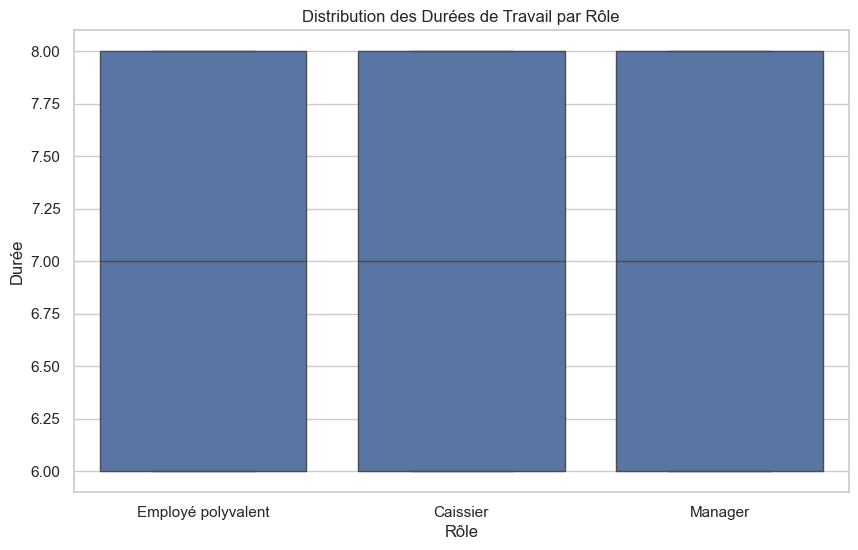

In [23]:
df_staff['Heure_début'] = pd.to_datetime(df_staff['Heure_début'])
df_staff['Heure_fin'] = pd.to_datetime(df_staff['Heure_fin'])
df_staff['Durée'] = (df_staff['Heure_fin'] - df_staff['Heure_début']).dt.total_seconds()/3600

plt.figure(figsize=(10,6))
sns.boxplot(x='Rôle', y='Durée', data=df_staff)
plt.title("Distribution des Durées de Travail par Rôle");

## **5. Analyse Météo**
### A. Impact sur les Ventes

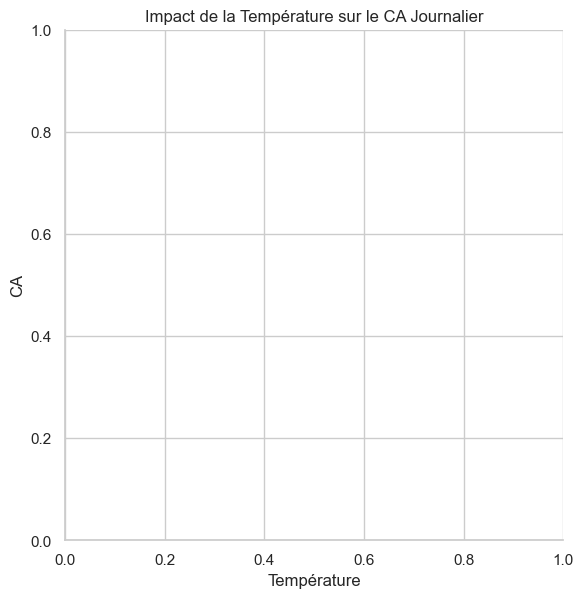

In [26]:
weather_impact = pd.merge(
    df_sales.groupby(['Date','Magasin'])['CA'].sum().reset_index(),
    df_weather,
    left_on=['Date','Magasin'],
    right_on=['Date','Ville']
)

sns.lmplot(x='Température', y='CA', data=weather_impact, height=6)
plt.title("Impact de la Température sur le CA Journalier");

## **6. Analyse Marketing**
### A. Performance des Campagnes

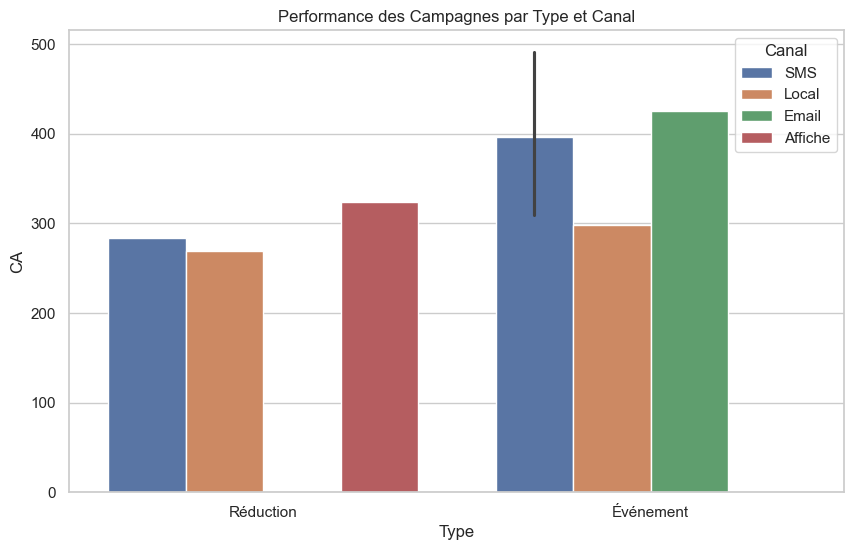

In [29]:
campaign_perf = pd.merge(
    df_marketing,
    df_sales.groupby(['Date','Magasin'])['CA'].sum(),
    left_on=['Date_début','Magasin'],
    right_on=['Date','Magasin']
)

plt.figure(figsize=(10,6))
sns.barplot(x='Type', y='CA', hue='Canal', data=campaign_perf)
plt.title("Performance des Campagnes par Type et Canal");

In [31]:
# Export des données transformées pour la modélisation
output_path = DATA_DIR / "ventes_enhanced.csv"
df_sales.to_csv(output_path, index=False)
print(f"💾 Données exportées vers {output_path}")

💾 Données exportées vers C:\Users\Optimiste\Videos\Freelance\quickmart_analysis\data\ventes_enhanced.csv
